Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [217]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [218]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [219]:
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)
train.shape, val.shape

((45042, 41), (14358, 41))

In [220]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2760
gps_height                   0
installer                 2772
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 272
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2498
recorded_by                  0
scheme_management         2964
scheme_name              21354
permit                    2311
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [221]:
import numpy as np
import pandas as pd

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random), num_private(all 0's)
    unusable_variance = ['recorded_by', 'id', 'num_private', 'amount_tsh', 'scheme_name']
    X = X.drop(columns=unusable_variance)

    # Drop source_class, similar to source but source has no missing values:
    similars = ['source_class', 'region', 'extraction_type_group', 'waterpoint_type_group',
                'quality_group', 'water_quality']
    X = X.drop(columns=similars)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [222]:
# construction year has 20709 0's, mean would be in 1300's not accurate,
# will do a year like 1950 which is before all the given years.
train['construction_year'].value_counts()

0       15691
2010     2044
2008     1992
2009     1929
2000     1563
2007     1211
2006     1122
2003      974
2011      944
2004      850
2012      822
2002      810
1995      779
1978      773
2005      761
1990      744
1998      742
1999      729
1985      705
1996      610
1984      601
1980      595
1982      570
1994      550
1972      538
1974      534
1992      496
1997      487
1993      476
2001      402
1988      384
1983      359
1975      328
1986      321
1976      320
1970      316
1991      239
1987      230
1989      224
1981      176
1977      158
1979      146
1973      141
2013      129
1971      103
1960       81
1963       69
1967       69
1968       58
1969       46
1964       32
1962       22
1961       18
1965       15
1966       14
Name: construction_year, dtype: int64

In [223]:
train.loc[train['construction_year'] <= 0, 
          train.columns=='construction_year'] = 1950
val.loc[val['construction_year'] <= 0, 
          val.columns=='construction_year'] = 1950
test.loc[test['construction_year'] <= 0, 
          test.columns=='construction_year'] = 1950
train['construction_year'].value_counts()[:5]

1950    15691
2010     2044
2008     1992
2009     1929
2000     1563
Name: construction_year, dtype: int64

In [224]:
train.shape

(45042, 34)

In [225]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [226]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [227]:
from sklearn.feature_selection import SelectKBest
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


my_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    SelectKBest(k=27),
    RandomForestClassifier(n_estimators=416, max_depth=20, 
                           max_features=0.18299052178915165, random_state=42, 
                           n_jobs=-1)
)
k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 3 folds: [0.800333   0.80418276 0.80483581]


In [228]:
from sklearn.feature_selection import SelectKBest
my_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    SelectKBest(k=27),
    RandomForestClassifier(n_estimators=416, max_depth=20, 
                           max_features=0.18299052178915165, random_state=42, 
                           n_jobs=-1)
)

my_pipeline.fit(X_train, y_train)
print('Train Accuracy', my_pipeline.score(X_train, y_train))
print('Validation Accuracy', my_pipeline.score(X_val, y_val))

Train Accuracy 0.9438746059233604
Validation Accuracy 0.8113943446162418


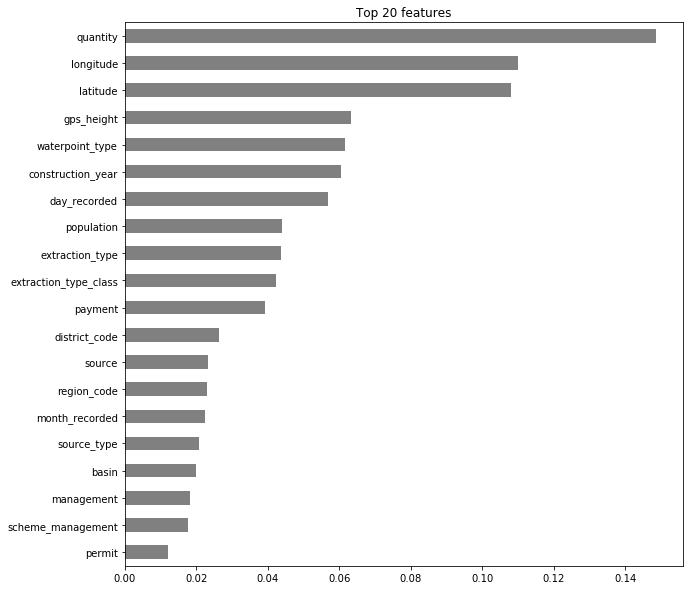

In [229]:
# feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf1 = my_pipeline.named_steps['randomforestclassifier']
encoder = my_pipeline.named_steps['ordinalencoder']
encoded1 = encoder.transform(X_train)
importances1 = pd.Series(rf1.feature_importances_, encoded1.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances1.sort_values()[-n:].plot.barh(color='grey');

In [233]:
import matplotlib
print(matplotlib.__version__)
!pip install matplotlib==3.1.0

3.1.1
     |████████████████████████████████| 14.4MB 3.3MB/s eta 0:00:01    |█▌                              | 655kB 3.3MB/s eta 0:00:05     |██████▍                         | 2.9MB 3.3MB/s eta 0:00:04
  Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1


In [236]:
from sklearn.metrics import confusion_matrix
y_pred = my_pipeline.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[7159,  122,  517],
       [ 606,  291,  146],
       [1259,   58, 4200]])

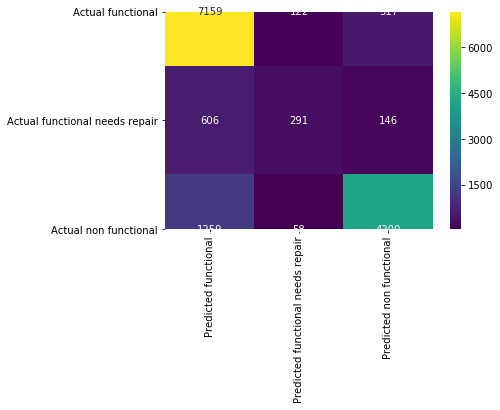

In [237]:
# 3. Plot a heatmap
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

In [238]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      7798
functional needs repair       0.62      0.28      0.38      1043
         non functional       0.86      0.76      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.76      0.65      0.68     14358
           weighted avg       0.81      0.81      0.80     14358

